In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy.stats as stats
import matplotlib.gridspec as gridspec

from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

base_dir = Path(os.getcwd()).resolve().parent
base_dir

WindowsPath('C:/Users/jfbot/Desktop/GHProjGrupo/ASTP')

In [4]:
df = pd.read_csv(base_dir/"data"/"USEPUINDXD.csv", index_col="observation_date", parse_dates=["observation_date"])
title = df.columns[0]
ylab = "Index Value"

In [5]:
df = df[df.index >= "2000-01-01"]
df.head()

,USEPUINDXD
observation_date,
2000-01-01,68.04
2000-01-02,119.36
2000-01-03,35.73
2000-01-04,109.31
2000-01-05,123.22


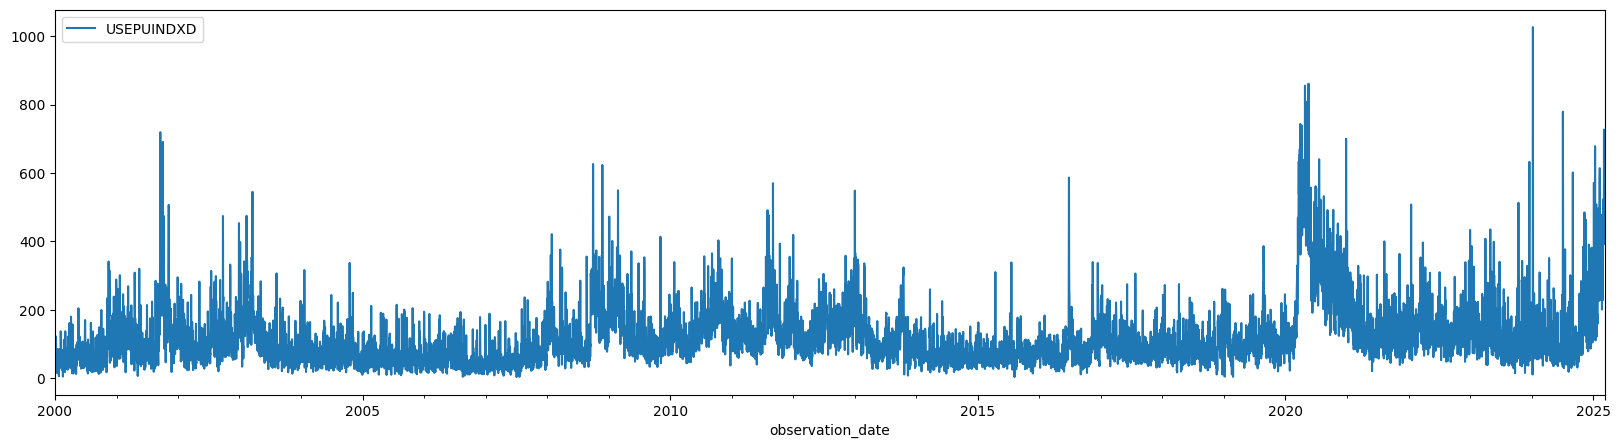

In [6]:
df.plot(figsize=(20,5))
plt.show()

C:\Users\jfbot\AppData\Local\Temp\ipykernel_17688\2821727830.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly = df.resample('M').mean()


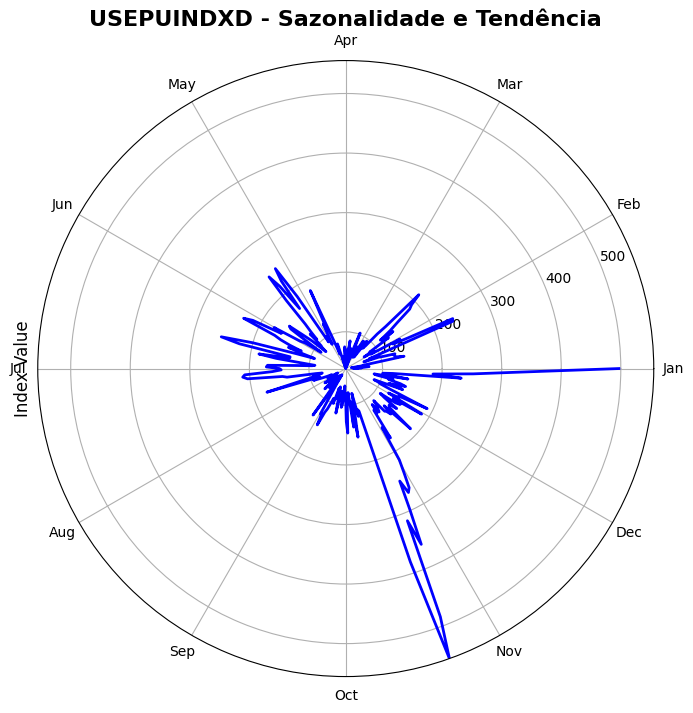

In [8]:
# Vamos usar a média mensal como exemplo
df_monthly = df.resample('M').mean()

# Calcular o ângulo para a visualização circular, baseado no número de meses
time = np.linspace(0, 2 * np.pi, len(df_monthly))  # 2*pi para um ano completo
values = df_monthly[title].values  # Valores da série temporal (média mensal)

# Criação do gráfico circular (polar)
plt.figure(figsize=(8, 8))
ax = plt.subplot(111, projection='polar')

# Plotando os dados no gráfico circular
ax.plot(time, values, color='blue', lw=2)

# Adicionando título e rótulos
ax.set_title(f'{title} - Sazonalidade e Tendência', fontsize=16, fontweight='bold')
ax.set_ylabel(ylab, fontsize=12)

# Opcional: ajustar para visualizar melhor os dados (ex: ajustar limites, marcar pontos de interesse)
ax.set_ylim(min(values), max(values))  # Limita o gráfico para os valores da série
ax.set_xticks(np.linspace(0, 2*np.pi, 12, endpoint=False))  # Marca as 12 divisões do ano
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=10)

# Exibir o gráfico
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9202 entries, 2000-01-01 to 2025-03-11
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   USEPUINDXD  9202 non-null   float64
dtypes: float64(1)
memory usage: 143.8 KB


In [10]:
print(df.describe(percentiles=[.1, .25, .5, .75, .9]))
print("var     %.6f" % np.var(df["USEPUINDXD"]))

        USEPUINDXD
count  9202.000000
mean    117.937791
std      87.761427
min       3.320000
10%      40.832000
25%      61.895000
50%      95.095000
75%     146.720000
90%     216.655000
max    1026.380000
var     7701.231087


<Figure size 2000x500 with 0 Axes>

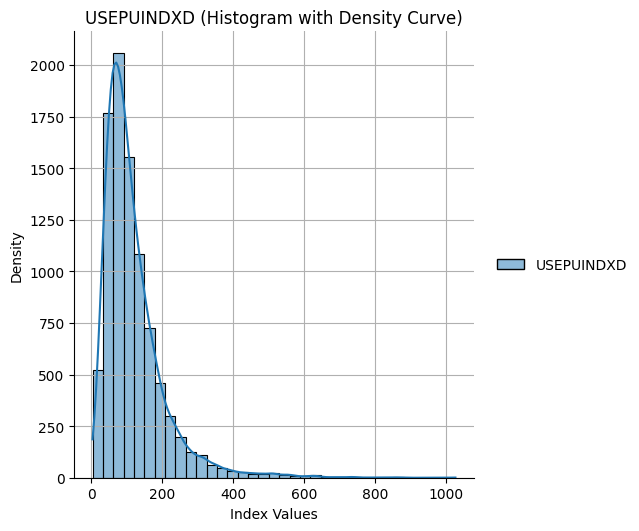

In [12]:
# Histogram plot with depicted density and rug
plt.figure(figsize=(20,5))
sns.displot(df,
             bins = 35,
            kind="hist",
             kde = True,
            )
plt.title(title + ' (Histogram with Density Curve)')
plt.ylabel('Density')
plt.xlabel("Index Values")
plt.grid(True)
plt.show()

In [13]:
df[df.columns[0]].value_counts(normalize=True).sort_index().cumsum()

USEPUINDXD
3.32       0.000109
3.38       0.000217
4.05       0.000326
4.15       0.000435
4.27       0.000543
             ...   
778.95     0.999565
807.66     0.999674
855.17     0.999783
861.10     0.999891
1026.38    1.000000
Name: proportion, Length: 7396, dtype: float64

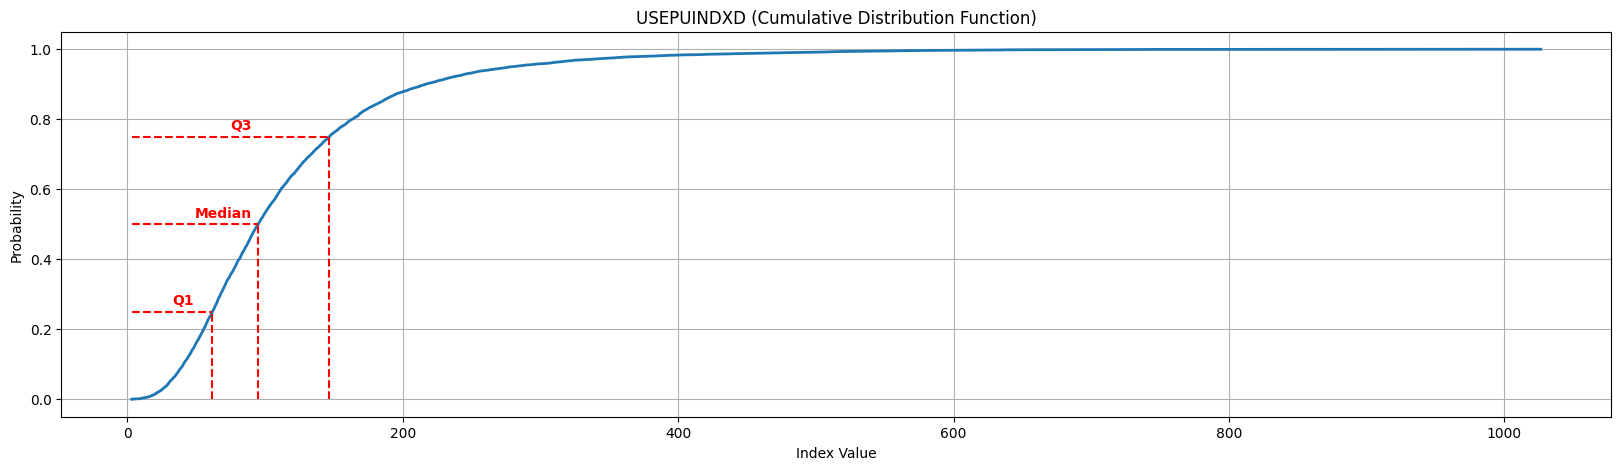

In [14]:
# Cumulative Distribution Function
cdf = df[df.columns[0]].value_counts(normalize=True).sort_index().cumsum()
cdf.plot(figsize=(20,5), linewidth=2)
plt.title(title + ' (Cumulative Distribution Function)')
plt.ylabel('Probability')
plt.xlabel("Index Value")
minVal = df.values.min()
q25 = np.quantile(df.values, .25)
medianVal = np.quantile(df.values, .5)
q75 = np.quantile(df.values, .75)
data=[(minVal, q25), (.25, .25), 'r', (q25, q25), (0, .25), 'r', \
      (minVal, medianVal), (.5, .5), 'r', (medianVal, medianVal), (0, .5), 'r', \
      (minVal, q75), (.75, .75), 'r', (q75, q75), (0, .75), 'r']
plt.plot(*data, ls='--');
plt.text(minVal+(q25-minVal)/2, 0.27, "Q1", color='r', fontweight='bold')
plt.text(minVal+(medianVal-minVal)/2, 0.52, "Median", color='r', fontweight='bold')
plt.text(minVal+(q75-minVal)/2, 0.77, "Q3", color='r',  fontweight='bold')
plt.grid(True)

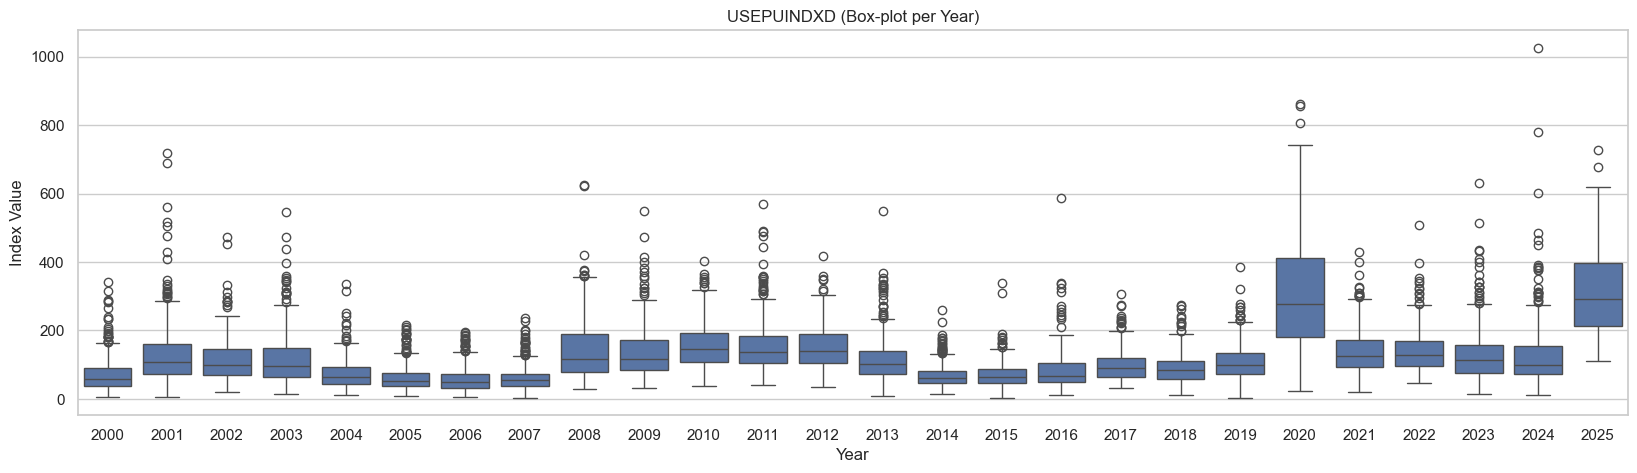

In [15]:
# Box and Whisker plot yearly
sns.set(rc={'figure.figsize':(20,5)})
sns.set(style="whitegrid")
box_plot = sns.boxplot(x=df.index.year, y=df.columns[0], data=df);
box_plot.set(xlabel='Year', ylabel=ylab, title= title + ' (Box-plot per Year)');

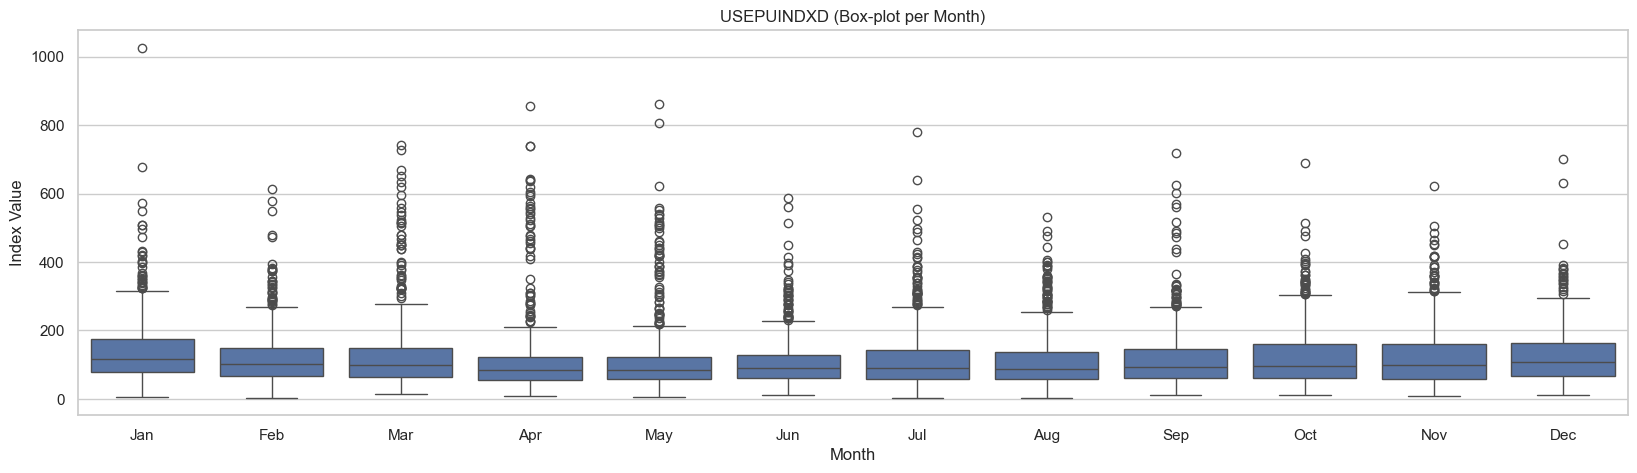

In [16]:
# Box and Whisker plot monthly
sns.set(rc={'figure.figsize':(20,5)})
sns.set(style="whitegrid")
box_plot = sns.boxplot(x=df.index.month, y=df.columns[0], data=df)
box_plot.set(xlabel='Month', ylabel=ylab, title= title + ' (Box-plot per Month)')
#box_plot.set_xticklabels(['Jan', 'Apr', 'Jul', 'Oct']);
box_plot.set_xticks(box_plot.get_xticks())
box_plot.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Data Analysis

In [17]:
seasonal_periods = 365

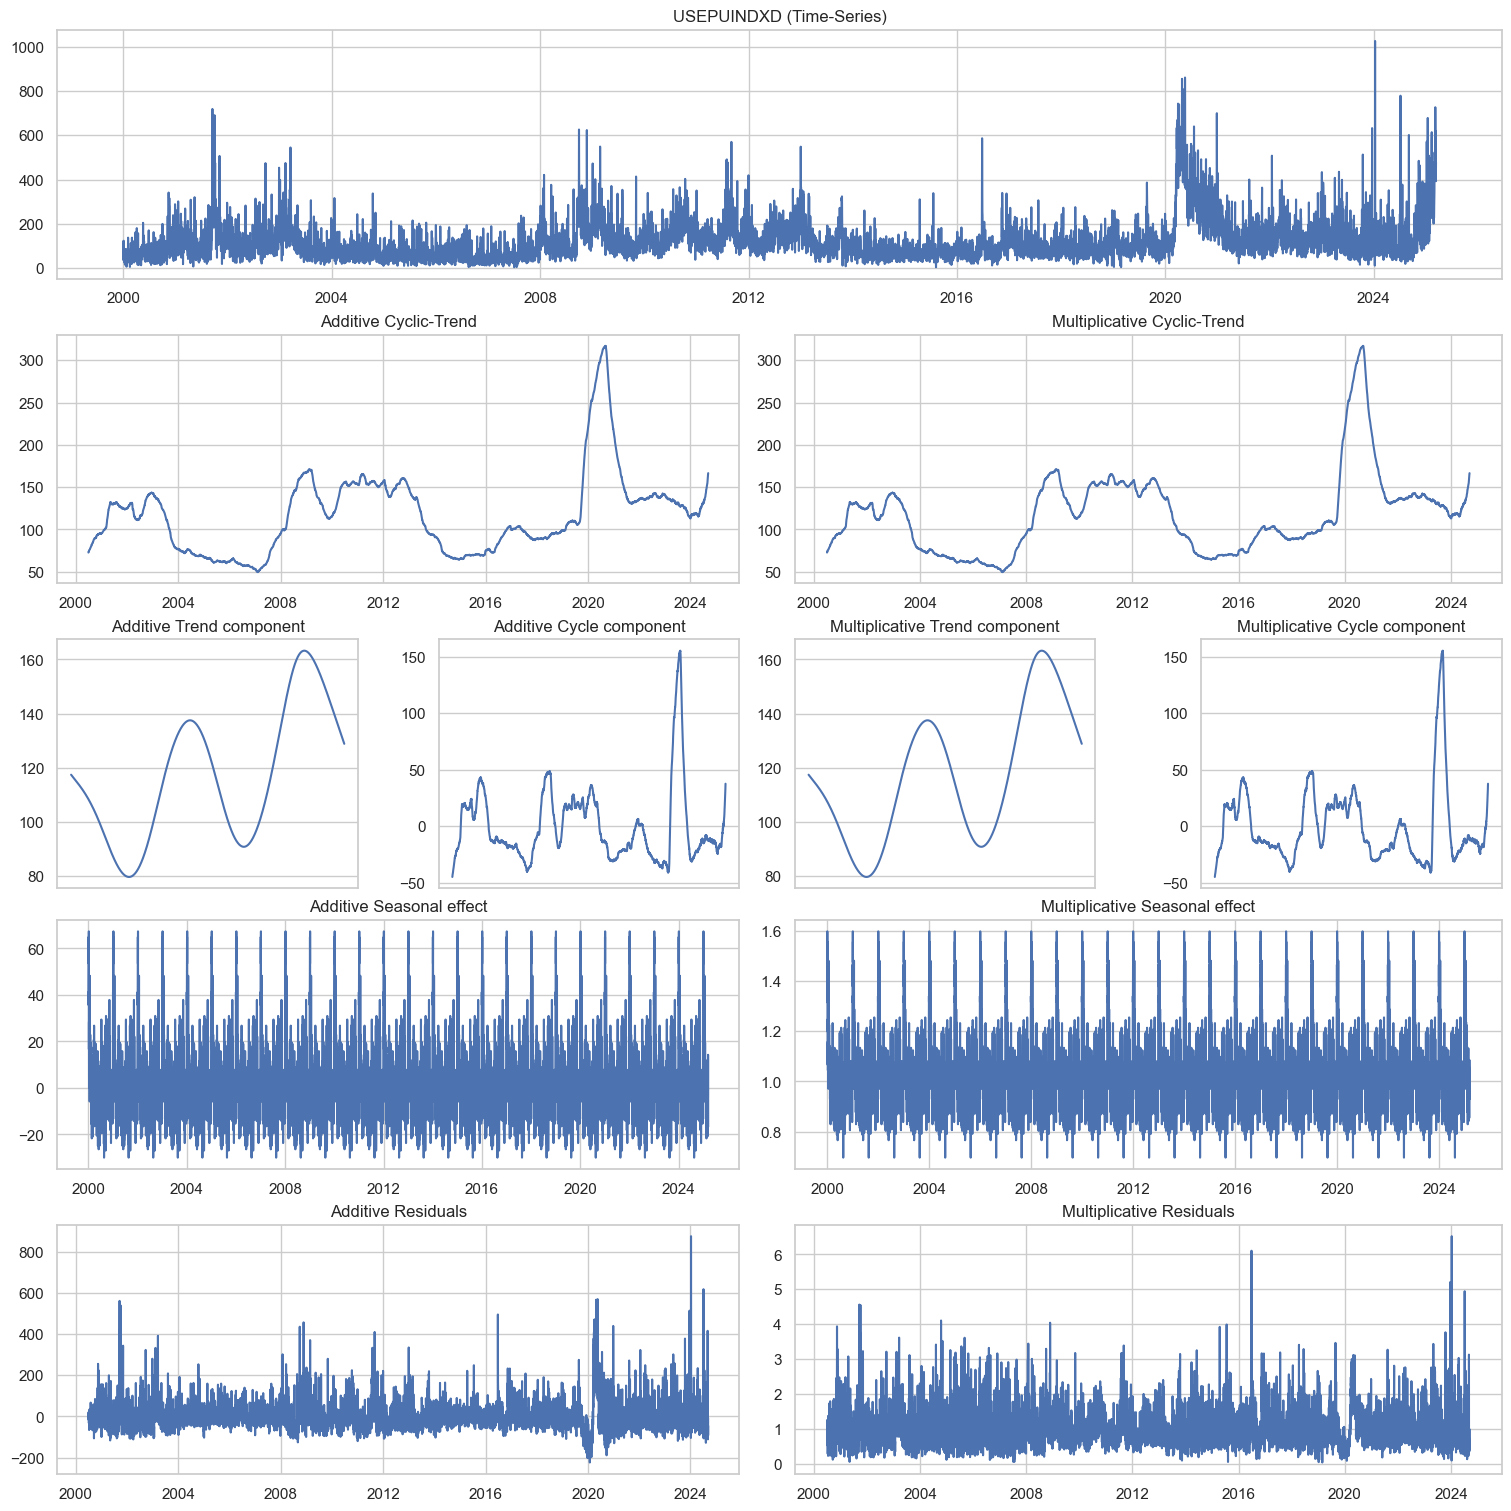

In [18]:
# As it should be known, a time series can typically be decomposed as:
#Additive Time Series = Level + CyclicTrend + Residual + Seasonality
#Multiplicative Time Series = Level*CyclicTrend*Residual*Seasonality

# Therefore, we will decompose the time series assuming it is both an additive and multiplicative model
#and we will infer in its type based on the residual fit given at the end

# Seasonal decomposition using moving averages
resultAdd = seasonal_decompose(df, model='additive',       period=seasonal_periods)
resultMul = seasonal_decompose(df, model='multiplicative', period=seasonal_periods)

# Hodrick-Prescott filter
# See Ravn and Uhlig: http://home.uchicago.edu/~huhlig/papers/uhlig.ravn.res.2002.pdf
lamb = 107360000000
cycleAdd, trendAdd = sm.tsa.filters.hpfilter(resultAdd.trend[resultAdd.trend.notna().values], lamb=lamb)
cycleMul, trendMul = sm.tsa.filters.hpfilter(resultMul.trend[resultMul.trend.notna().values], lamb=lamb)

fig = plt.figure(figsize=(15,15), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=5, figure=fig)

fig.add_subplot(spec[0, :])
plt.plot(df)

plt.title(title + ' (Time-Series)')
# Additive model
fig.add_subplot(spec[1, :2])
plt.plot(resultAdd.trend)
plt.title('Additive Cyclic-Trend')
fig.add_subplot(spec[2, 0])
plt.plot(trendAdd)
plt.xticks([])
plt.title('Additive Trend component')
fig.add_subplot(spec[2, 1])
plt.plot(cycleAdd)
plt.xticks([])
plt.title('Additive Cycle component')
fig.add_subplot(spec[3, :2])
plt.plot(resultAdd.seasonal)
plt.title('Additive Seasonal effect')
fig.add_subplot(spec[4, :2])
plt.plot(resultAdd.resid)
plt.title('Additive Residuals')

# Multiplicative model
fig.add_subplot(spec[1, 2:])
plt.plot(resultMul.trend)
plt.title('Multiplicative Cyclic-Trend')
fig.add_subplot(spec[2, 2])
plt.plot(trendMul)
plt.xticks([])
plt.title('Multiplicative Trend component')
fig.add_subplot(spec[2, 3])
plt.plot(cycleMul)
plt.xticks([])
plt.title('Multiplicative Cycle component')
fig.add_subplot(spec[3, 2:])
plt.plot(resultMul.seasonal)
plt.title('Multiplicative Seasonal effect')
fig.add_subplot(spec[4, 2:])
plt.plot(resultMul.resid)
plt.title('Multiplicative Residuals')
plt.show()

In [19]:
print("Time-Series Level is " + str(round(df.mean()[0], 2)))
print("")
print("Additive Time Series")
#FtAdd = max(0, 1-np.var(resultAdd.resid)[0]/np.var(resultAdd.trend)[0]); #inicial
FtAdd = max(0, 1-np.var(resultAdd.resid)/np.var(resultAdd.trend)); # Removed [0]

print("Strenght of Trend: %.4f" % FtAdd )
#FsAdd = max(0, 1-np.var(resultAdd.resid)[0]/np.var(resultAdd.seasonal)[0]); #inicial
FsAdd = max(0, 1-np.var(resultAdd.resid)/np.var(resultAdd.seasonal)); # Removed [0]

print("Strenght of Seasonality: %.4f" % FsAdd )
print("")
print("Multiplicative Time Series")
#FtMul = max(0, 1-np.var(resultMul.resid)[0]/np.var(resultMul.trend)[0]); #inicial
FtMul = max(0, 1-np.var(resultMul.resid)/np.var(resultMul.trend)); # Removed [0]

print("Strenght of Trend: %.4f" % FtMul )
#FsMul = max(0, 1-np.var(resultMul.resid)[0]/np.var(resultMul.seasonal)[0]); #inicial
FsMul = max(0, 1-np.var(resultMul.resid)/np.var(resultMul.seasonal)); # Removed [0]

print("Strenght of Seasonality: %.4f" % FsMul )

Time-Series Level is 117.94

Additive Time Series
Strenght of Trend: 0.0000
Strenght of Seasonality: 0.0000

Multiplicative Time Series
Strenght of Trend: 0.9999
Strenght of Seasonality: 0.0000


C:\Users\jfbot\AppData\Local\Temp\ipykernel_17688\1994755360.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Time-Series Level is " + str(round(df.mean()[0], 2)))


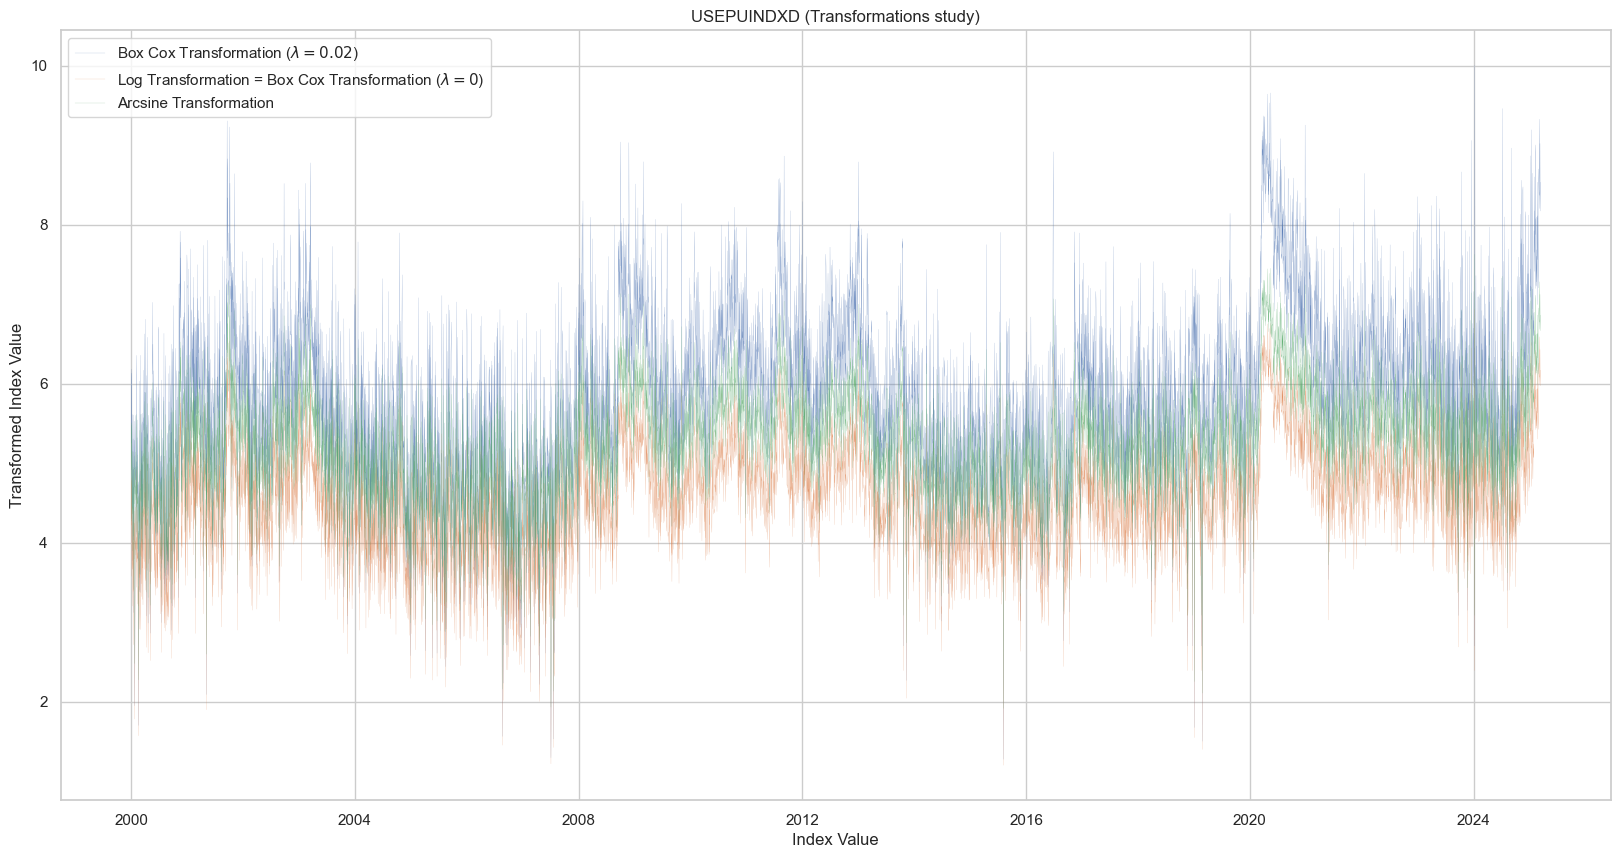

In [20]:
# Data Normalization
fig = plt.figure(figsize=(20,10))
# The Box-Cox transformation intends to transform data to be closer to normality,
#or tranform heteroskedastic (non constant variance) data to be closer to homoskedasticity (constant variance).
plt.plot(df.index, stats.boxcox(df.values, lmbda=.1), label = 'Box Cox Transformation '+u'($\lambda=0.02$)', lw=.1)
# The log transform (particular Box-Cox case) can be used where the data has a positively skewed distribution,
#and there are a few very large values. If the latter is in the area of study,
#the transform is likely to make variance more constant and normalize data
plt.plot(df.index, stats.boxcox(df.values, lmbda=0), label = 'Log Transformation = Box Cox Transformation '+u'($\lambda=0$)', lw=.1)
# The arcsine transformation will help make the variances more constant throughout
#your study area and often makes the data appear normally distributed as well.
plt.plot(df.index, np.arcsinh(df.values), label = 'Arcsine Transformation', lw=.1)

plt.legend(loc='best')
plt.title(title + ' (Transformations study)')
plt.xlabel("Index Value")
plt.ylabel('Transformed ' + ylab)
plt.show()

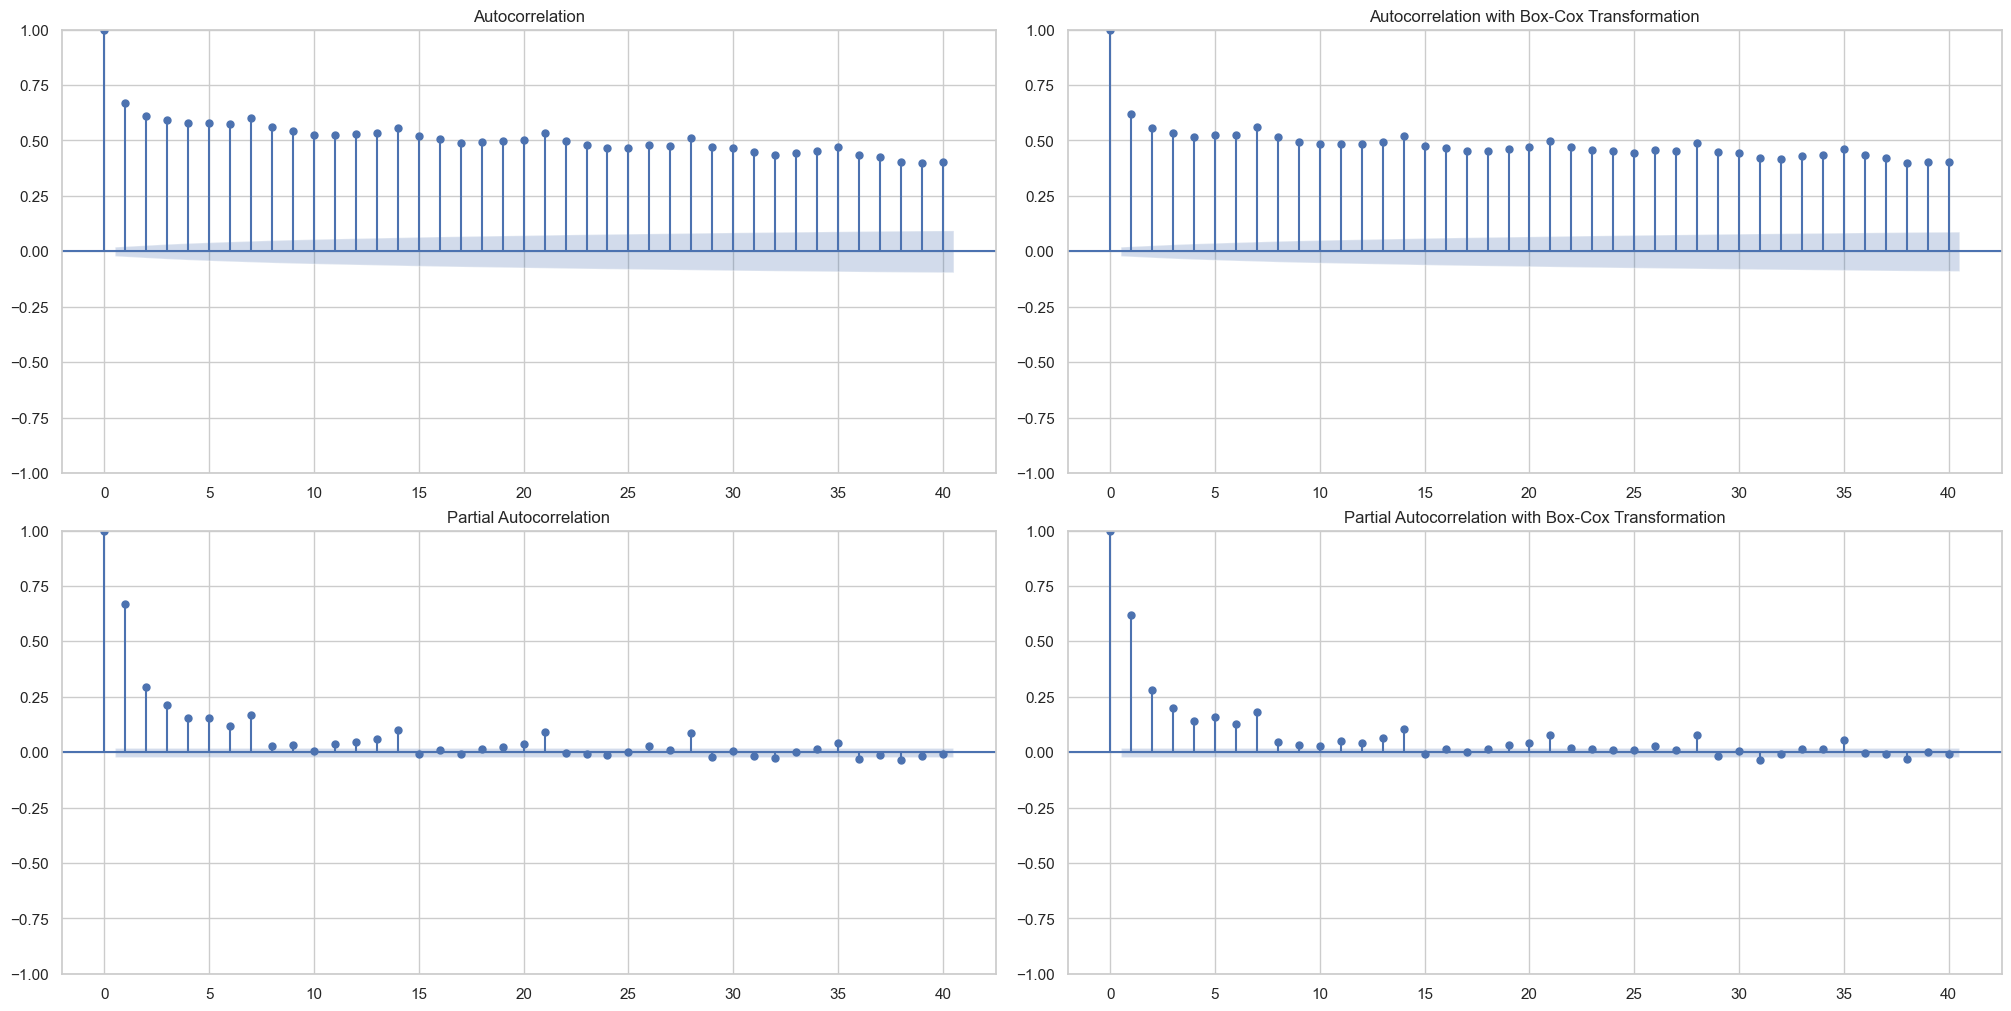

In [21]:
# Correlation plots
maxLags = 40
# The effect of applying Box-Cox transformation against original time series
df_boxCox = stats.boxcox(df.values, lmbda=0)

fig = plt.figure(figsize=(20,10), constrained_layout=True)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)

# Auto-correlation function for original time series
ax_acf = fig.add_subplot(spec[0, 0])
sm.graphics.tsa.plot_acf(df, lags=maxLags, ax=ax_acf)
# Partial auto-correlation function for original time series
ax_pacf = fig.add_subplot(spec[1, 0])
sm.graphics.tsa.plot_pacf(df, lags=maxLags, ax=ax_pacf);

# Auto-correlation function for time series transformed with Box-Cox
ax_acfBoxCox = fig.add_subplot(spec[0, 1])
sm.graphics.tsa.plot_acf(df_boxCox, lags=maxLags, ax=ax_acfBoxCox, title='Autocorrelation with Box-Cox Transformation')
# Partial auto-correlation function for time series transformed with Box-Cox
ax_pacfBoxCox = fig.add_subplot(spec[1, 1])
sm.graphics.tsa.plot_pacf(df_boxCox, lags=maxLags, ax=ax_pacfBoxCox, title='Partial Autocorrelation with Box-Cox Transformation');


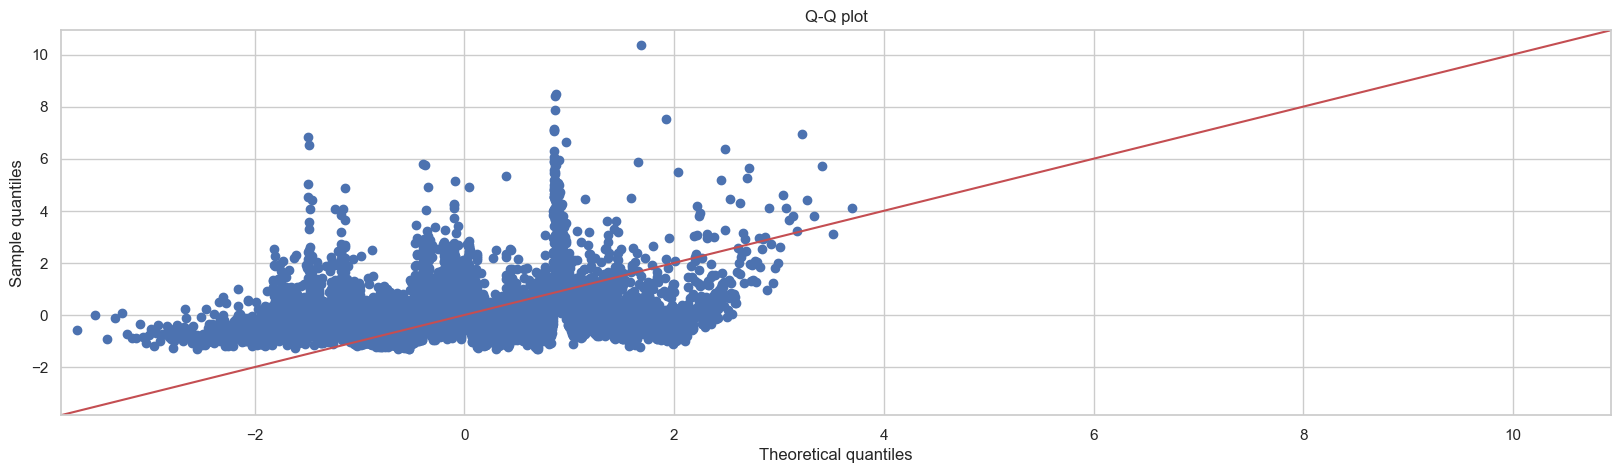

In [22]:
# Q-Q plot
# Compare time series against a standard normal curve
qqplot(df.values, stats.distributions.norm, fit=True, line='45')
plt.title('Q-Q plot')
plt.ylabel('Sample quantiles')
plt.xlabel('Theoretical quantiles')
plt.grid(True)

# **Hypothesis Test**

In [23]:
serie = df.columns[0]

In [24]:
# Kurtosis
# Measures height and sharpness of the central peak relative to that of a standard bell curve
k, kpval = kurtosistest(df)
kurtosis_val = kurtosis(df, fisher=True)
print("Kurtosis Test for " + serie)
print("Statistic: %.4f" % k[0])
print("p-value: %.4f" % kpval[0])
print(" ")
print("Kurtosis value: %.4f" % kurtosis_val[0])

Kurtosis Test for USEPUINDXD
Statistic: 40.4966
p-value: 0.0000
 
Kurtosis value: 10.3509


In [25]:
# Skewness
# Measure of the asymmetry of the probability distribution of a random variable about its mean
s, spval = skewtest(df)
skew_val = skew(df)
print("Skew Test for " + serie)
print("Statistic: %.4f" % s[0])
print("p-value: %.4f" % spval[0])
print(" ")
print("Skewness value: %.4f" % skew_val[0])

Skew Test for USEPUINDXD
Statistic: 59.0458
p-value: 0.0000
 
Skewness value: 2.5163


In [26]:
# Jarque-Bera goodness of fit test on sample data
# Tests if the sample data has the skewness and kurtosis matching a normal distribution
jb, jbpval= stats.jarque_bera(df)
print("Jarque-Bera Test for " + serie)
print("Statistic: %.4f" % jb)
print("p-value: %.4f" % jbpval)

Jarque-Bera Test for USEPUINDXD
Statistic: 50789.8483
p-value: 0.0000


In [27]:
# Kolmogorov-Smirnov Test goodness of fit test on sample data
ks, kspval = stats.kstest(df.values, 'norm')
print("Kolmogorov-Smirnov Test for " + serie)
print("Statistic: %.4f" % ks[0])
print("p-value: %.4f" % kspval[0])

Kolmogorov-Smirnov Test for USEPUINDXD
Statistic: 0.9998
p-value: 0.0000


In [28]:
# Engle's Test for Autoregressive Conditional Heteroscedasticity (ARCH)
lm, lmpval, fval, fpval = het_arch(df[df.columns.values[0]].values)
print("Lagrange Multiplier Test for " + serie)
print("Statistic: %.4f" % lm)
print("p-value: %.4f" % lmpval)
print(" ")
print("fstatistic for F test")
print("Statistic: %.4f" % fval)
print("p-value: %.4f" % fpval)

Lagrange Multiplier Test for USEPUINDXD
Statistic: 4491.1793
p-value: 0.0000
 
fstatistic for F test
Statistic: 877.1557
p-value: 0.0000


In [29]:
# The Augmented Dickey-Fuller test
# Used to test for a unit root in a univariate process in the presence of serial correlation.
#regression{‘c’,’ct’,’ctt’,’nc’} 'c' - Constant and 't'-trend order to include in regression
    #Note: 'ct' - The data is stationary around a trend
result = adfuller(df[df.columns.values[0]].values, regression='c')
print("Augmented Dickey-Fuller Test for " + serie)
print("ADF Statistic: %.4f" % result[0])
print("p-value: %.4f" % result[1])
print("Used lags: %d" % result[2])
print("Num obs: %d" % result[3])
print("Critical Values:")
d = OrderedDict(sorted(result[4].items(), key=lambda t: t[1]))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Augmented Dickey-Fuller Test for USEPUINDXD
ADF Statistic: -5.2612
p-value: 0.0000
Used lags: 38
Num obs: 9163
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [30]:
# Kwiatkowski-Phillips-Schmidt-Shin test
# Test for level or trend stationarity
# Note: regressionstr{‘c’, ‘ct’}
#regressionstr{‘c’, ‘ct’} wher:
    # ‘c’  : The data is stationary around a constant (default).
    # ‘ct’ : The data is stationary around a trend.
#lags{None, ‘auto’, ‘legacy’}
    # see: https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.kpss.html
result = kpss(df[df.columns.values[0]].values, regression='c')
print("Kwiatkowski-Phillips-Schmidt-Shin Test for " + serie)
print("KPSS Statistic: %.4f" % result[0])
print("Critical Values:")
d = OrderedDict(sorted(result[3].items(), key=lambda t: t[1], reverse=True))
for key, value in d.items():
    print("\t%s: %.3f" % (key, value))

Kwiatkowski-Phillips-Schmidt-Shin Test for USEPUINDXD
KPSS Statistic: 1.7386
Critical Values:
	1%: 0.739
	2.5%: 0.574
	5%: 0.463
	10%: 0.347


C:\Users\jfbot\AppData\Local\Temp\ipykernel_17688\1865977507.py:9: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(df[df.columns.values[0]].values, regression='c')


In [31]:
# Computing Brock Dechert and Scheinkman test
# Tests independent and identically distributed (i.i.d.) time series
result = bds(df[df.columns.values[0]].values, max_dim=6)
print("Brock Dechert and Scheinkman Test for " + serie)
print("Dim 2: z-static %.4f Prob %.4f" % (result[0][0], result[1][0]))
print("Dim 3: z-static %.4f Prob %.4f" % (result[0][1], result[1][1]))
print("Dim 4: z-static %.4f Prob %.4f" % (result[0][2], result[1][2]))
print("Dim 5: z-static %.4f Prob %.4f" % (result[0][3], result[1][3]))
print("Dim 6: z-static %.4f Prob %.4f" % (result[0][4], result[1][4]))

Brock Dechert and Scheinkman Test for USEPUINDXD
Dim 2: z-static 67.8278 Prob 0.0000
Dim 3: z-static 70.2430 Prob 0.0000
Dim 4: z-static 70.4328 Prob 0.0000
Dim 5: z-static 70.7899 Prob 0.0000
Dim 6: z-static 71.6955 Prob 0.0000
